In [1]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# process
from keras.preprocessing.image import ImageDataGenerator

# dl libraries
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.utils import to_categorical

# for cnn
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

import cv2                  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image


Using TensorFlow backend.


In [2]:
X = []
Z = []
IMG_SIZE = 150
FLOWER_DAISY_DIR ='./flowers/daisy'
FLOWER_SUNFLOWER_DIR ='./flowers/sunflower'
FLOWER_TULIP_DIR ='./flowers/tulip'
FLOWER_DANDI_DIR ='./flowers/dandelion'
FLOWER_ROSE_DIR ='./flowers/rose'

In [3]:
def assign_label(img, flower_type):
    return flower_type

def make_train_data(flower_type, DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img, flower_type)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [4]:
make_train_data('Daisy', FLOWER_DAISY_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████| 769/769 [00:12<00:00, 60.72it/s]


769


In [5]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████| 734/734 [00:10<00:00, 53.29it/s]


1503


In [6]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████| 984/984 [00:21<00:00, 44.77it/s]


2487


In [7]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████████████████████████████████████████████████████| 1052/1052 [00:33<00:00, 31.31it/s]


3539


In [8]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████| 784/784 [00:07<00:00, 98.54it/s]


4323


## Visualizing some random images

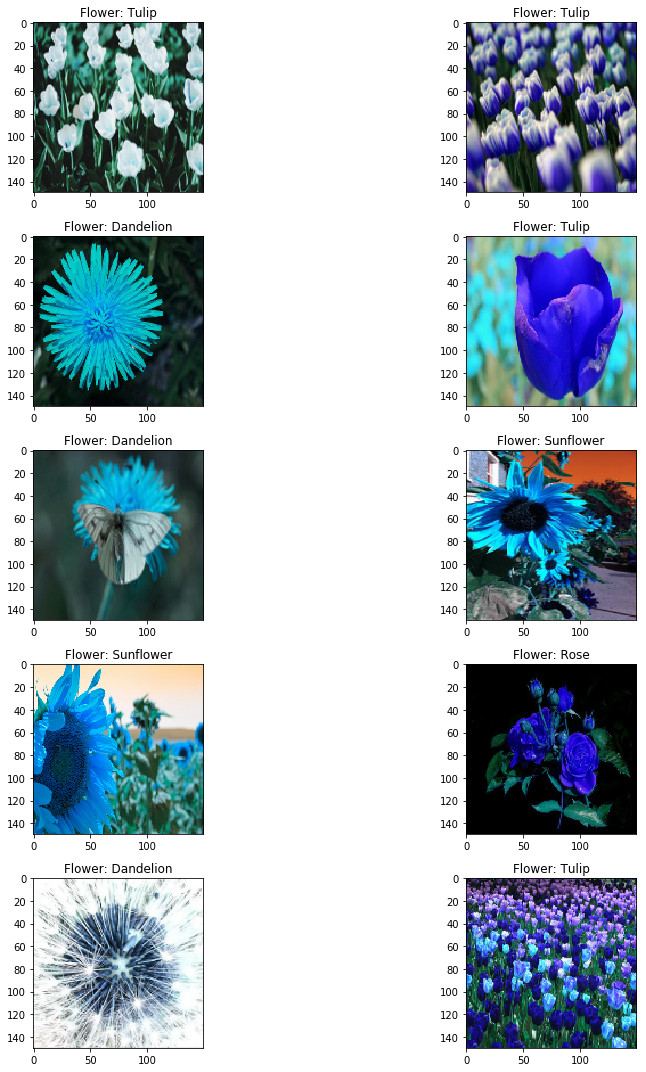

In [9]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [10]:
# label encoding the Y array (i.e. Daisy = 0, Rose = 1, etc) and then hot encoding
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, 5)
X = np.array(X)
X = X / 255

In [11]:
# splitting into training and validation sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [12]:
# setting random seeds
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

## Modelling

In [13]:
# build convNet model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation='softmax'))



In [14]:
#using a LR Annealer

batch_size = 128
epochs = 50

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1)

In [15]:
# data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [16]:
# compiling the keras model and summary
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 31104)             0         
__________

In [19]:
# History = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                               epochs=epochs, validation_data=(x_test,y_test),
#                               verbose=1, steps_per_epoch=x_train.shape[0] // batch_size)

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[128,64,75,75] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/max_pooling2d_2/MaxPool_grad/MaxPoolGrad}} = MaxPoolGrad[T=DT_FLOAT, data_format="NCHW", ksize=[1, 1, 2, 2], padding="VALID", strides=[1, 1, 2, 2], _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_2/Relu, max_pooling2d_2/MaxPool, training/Adam/gradients/conv2d_3/convolution_grad/Conv2DBackpropInput)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
